In [2]:
# Box Score Scraper
# David Freed and Samuel Green
# February 29, 2016

In [3]:
%matplotlib inline 

import requests
from bs4 import BeautifulSoup
from bs4 import NavigableString
import pandas as pd
import StringIO
import urllib
from datetime import date, datetime
import itertools
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from scipy.stats.stats import pearsonr
import math
import sys

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

plt.style.use('ggplot')

In [4]:
# Simple lambda function
def split(x, num):
    return int(x.split('-')[num])

In [9]:
# Write a function that scrapes the team trend graph for each game
# Find game id by going to box scores and taking the end of the url
def nbatrendgraph(gameid):

    # Scrape the reference team page
    url = 'http://espn.go.com/nba/playbyplay?gameId=' + str(gameid)
    html = urllib.urlopen(url)
    soup = BeautifulSoup(html, "html.parser") 

    # Identify which team is which from the basic page
    teams = soup.find_all('div', {'class', "team-container"})

    away = str(teams[0].contents[0].find('img')['src'].split('/')[-1].split('.')[0]).upper()
    home = str(teams[1].contents[0].find('img')['src'].split('/')[-1].split('.')[0]).upper()

    # Run through the table and get all the relevant events from that quarter
    qes = []
    for num in range(1,5):
        for item in soup.find_all('table')[num].find_all('tr')[1:]:
            event = []
            for td in item.find_all('td'):
                if len(td.contents) > 0:
                    if 'img' in str(td.contents[0]):
                        event.append(str(td.contents[0]['src']).split('/')[-1].split('.')[0].upper())
                    else:
                        if ':' in str(td.contents[0]):
                            minutes = 11-int(td.contents[0].split(':')[0]) +((num-1)*12)
                            seconds = 60-int(td.contents[0].split(':')[1])

                            # Make an adjustment for exact minute calculations
                            if seconds == 60:
                                minutes = minutes + 1
                                seconds = 0

                            event.append(minutes)
                            event.append(seconds)
                        else:
                            event.append(str(td.contents[0]))
            qes.append(event)

    # Make this data into a Dataframe
    bsd = pd.DataFrame(qes, columns = ['Minutes', 'Seconds', 'Team', 'Event', 'Score'])
    bsd[away] = bsd['Score'].apply(lambda x: split(x, 0))
    bsd[home] = bsd['Score'].apply(lambda x: split(x, 1))
    bsd = bsd.drop('Score', 1)

    # Write a quick function converting the minutes and seconds to a percentage
    lengame = 48*60.0
    bsd['PercDone'] = [float(100*round((mins*60+sec)/lengame,4)) for (mins, sec) in zip(bsd['Minutes'], bsd['Seconds'])]

    # Make a quick line graph of the scores over time
    fig = plt.figure(figsize=(14,14))
    plt.title('Game Trends: ' + away + ' at ' + home, fontsize = 16)
    plt.xlabel('Percent of Game Completed', fontsize = 16)
    plt.ylabel('Points', fontsize = 16)
    plt.plot(list(bsd['PercDone']), list(bsd[away]), c = 'r')
    plt.plot(list(bsd['PercDone']), list(bsd[home]), c = 'b')

    # Plot quarter boundaries
    plt.axvline(x=25, linewidth = 0.5, color='gray')
    plt.axvline(x=50, linewidth = 0.5, color='gray')
    plt.axvline(x=75, linewidth = 0.5, color='gray')

    red_patch = mpatches.Patch(color='red', label=away)
    blue_patch = mpatches.Patch(color='blue', label=home)
    plt.legend(handles=[red_patch, blue_patch], loc = 2, fontsize = 16)
    plt.grid()
    plt.show()
    
    return bsd

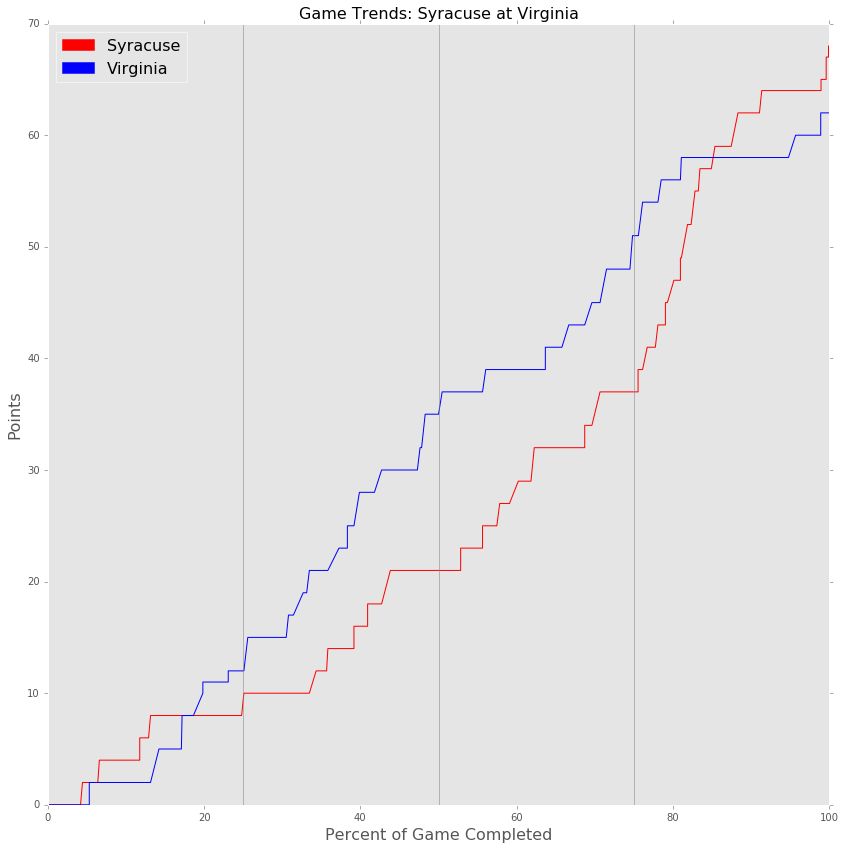

In [12]:
ncaatrendgraph(400873156)

In [11]:
# Write a function that scrapes the team trend graph for each game
# Find game id by going to box scores and taking the end of the url
def ncaatrendgraph(gameid):

    # Scrape the reference team page
    url = 'http://espn.go.com/mens-college-basketball/playbyplay?gameId=' + str(gameid)
    html = urllib.urlopen(url)
    soup = BeautifulSoup(html, "html.parser") 

    # Identify which team is which from the basic page
    teams = soup.find_all('div', {'class', "team-container"})

    away = str(teams[0].find('span', {'class', 'long-name'}).contents[0]).split(';')[0]
    home = str(teams[1].find('span', {'class', 'long-name'}).contents[0]).split(';')[0]

    # # Run through the table and get all the relevant events from that quarter
    qes = []
    tps = (len(soup.find('div', {'class', 'game-status'}).find('table').find_all('td'))-2)/2
    for num in range(1,tps):
        for item in soup.find_all('table')[num].find_all('tr')[1:]:
            event = []
            for td in item.find_all('td'):
                if len(td.contents) > 0:
                    if 'img' in str(td.contents[0]):
                        event.append(str(td.contents[0]['src']).split('/')[-1].split('.')[0].upper())
                    else:
                        if ':' in str(td.contents[0]):
                            if num > 2:
                                minutes = 4-int(td.contents[0].split(':')[0]) + 40 + ((num-3)*5)
                            else:
                                minutes = 19-int(td.contents[0].split(':')[0]) +((num-1)*20)
                            seconds = 60-int(td.contents[0].split(':')[1])

                            # Make an adjustment for exact minute calculations
                            if seconds == 60:
                                minutes = minutes + 1
                                seconds = 0

                            event.append(minutes)
                            event.append(seconds)
                        else:
                            event.append(str(td.contents[0]))
            qes.append(event)

    # Make this data into a Dataframe
    bsd = pd.DataFrame(qes, columns = ['Minutes', 'Seconds', 'Team', 'Event', 'Score'])
    bsd[away] = bsd['Score'].apply(lambda x: split(x, 0))
    bsd[home] = bsd['Score'].apply(lambda x: split(x, 1))
    bsd = bsd.drop('Score', 1)

    # # Write a quick function converting the minutes and seconds to a percentage
    if (tps) == 3:
        numminutes = 40
    else:
        numminutes = 40 + 5*(tps-3)
    lengame = numminutes*60.0
    bsd['PercDone'] = [float(100*round((mins*60+sec)/lengame,4)) for (mins, sec) in zip(bsd['Minutes'], bsd['Seconds'])]

    # Make a quick line graph of the scores over time
    fig = plt.figure(figsize=(14,14))
    plt.title('Game Trends: ' + away + ' at ' + home, fontsize = 16)
    plt.xlabel('Percent of Game Completed', fontsize = 16)
    plt.ylabel('Points', fontsize = 16)
    plt.plot(list(bsd['PercDone']), list(bsd[away]), c = 'r')
    plt.plot(list(bsd['PercDone']), list(bsd[home]), c = 'b')

    # Plot quarter boundaries
    plt.axvline(x=25, linewidth = 0.5, color='gray')
    plt.axvline(x=50, linewidth = 0.5, color='gray')
    plt.axvline(x=75, linewidth = 0.5, color='gray')

    red_patch = mpatches.Patch(color='red', label=away)
    blue_patch = mpatches.Patch(color='blue', label=home)
    plt.legend(handles=[red_patch, blue_patch], loc = 2, fontsize = 16)
    plt.grid()
    plt.show()

In [297]:
first_round =  {'(16) Austin Peay v. (1) Kansas': 400871129,
                '(16) Florida Gulf Coast v. (1) North Carolina': 400871258,
                '(16) Hampton v. (1) Virginia: ': 400871284,
                '(14) Buffalo v. (3) Miami': 400871272,
                '(13) Stony Brook v. (4) Kentucky': 400871260,
                '(12) Arkansas Little-Rock v. (5) Purdue': 400871264,
                '(14) Fresno State v. (3) Utah': 400871266,
                '(12) Chattanooga v. (5) Indiana': 400871259,
                '(11) Wichita St v. (6) Arizona': 400871273,
                '(13) UNC-Wilmington v. (4) Duke': 400871255,
                '(11) Gonzaga v. (6) Seton Hall': 400871287,
                '(12) Yale v. (5) Baylor': 400871276,
                '(13) Iona v. (4) Iowa State': 400871285,
                '(9) Butler v. (8) Texas Tech': 400871263,
                '(9) UConn v. (8) Colorado': 400871250,
                '(9) Providence v. (8) USC': 400871280,
                '(15) Middle Tennessee v. (2) Michigan State': 400871286,
                '(16) Holy Cross v. (1) Oregon': 400871253,
                '(15) UNC-Asheville v. (2) Villanova': 400871251,
                '(15) CSU Bakersfield v. (2) Oklahoma': 400871256,
                '(14) Stephen F. Austin v. (3) West Virginia': 400871261,
                '(15) Weber State v. (2) Xavier': 400871281,
                '(14) Green Bay v. (3) Texas A&M': 400871278,
                '(12) South Dakota State v. (5) Maryland': 400871270,
                '(13) Hawaii v. (4) California': 400871271,
                '(10) Temple v. (7) Iowa': 400871252, 
                '(10) Syracuse v. (7) Dayton': 400871265, 
                '(10) VCU v. (7) Oregon State': 400871277, 
                '(10) Pittsburgh v. (7) Wisconsin': 400871282, 
                '(11) Northern Iowa v. (6) Texas': 400871257,
                '(11) Michigan v. (6) Notre Dame': 400871262,  
                "(9) Cincinnati v. (8) St. Joseph's": 400871275}

second_round =  {'(9) UConn v. (1) Kansas': 400872131,
                 '(9) Providence v. (1) UNC': 400872165,
                 '(9) Butler v. (1) Virginia': 400872129,
                 '(11) Wichita State v. (3) Miami': 400872163,
                 '(5) Indiana v. (4) Kentucky': 400872166,
                 '(11) Gonzaga v. (3) Utah': 400872167,
                 '(12) Yale v. (4) Duke': 400872082,
                 '(12) Arkansas-Little Rock v. (4) Iowa State': 400872132,
                 "(8) Saint Joseph's v. (1) Oregon": 400872255,
                 '(7) Iowa v. (2) Villanova': 400872214,
                 '(10) VCU v. (2) Oklahoma': 400872224,
                 '(7) Wisconsin v. (2) Xavier': 400872259,
                 '(11) Northern Iowa v. (3) Texas A&M': 400872229,
                 '(13) Hawaii v. (5) Maryland': 400872218,
                 '(14) Stephen F. Austin v. (6) Notre Dame': 400872251,
                 '(15) Middle Tennessee v. (10) Syracuse': 400872223} 

sweet_sixteen = {''}

elite_eight = {''}

In [298]:
# Easily bring up graphs from every game
def userprompt():
    # Sort through the types of games
    print "Please choose one of the following options (type exactly as written): "
    print "1. First Round Games"
    print "2. Second Round Games"
    var1 = raw_input("Enter your choice here: ")
    
    if "First" in var1:
        print ""
        print "------"
        print ""
        for item in first_round:
            print item
        var2 = raw_input("Enter your choice here: ")
        ncaatrendgraph(first_round[var2])
    elif "Second" in var1:
        print ""
        print "------"
        print ""
        for item in second_round:
            print item
        var2 = raw_input("Enter your choice here: ")
        ncaatrendgraph(second_round[var2])
    else:
        print "Input Error"

In [305]:
# Create the win probability graphs

# For a given game, find the scores at every second, along with the initial spread and the winner
def scorebytime(gameid):

    # Scrape the spread
    url2 = 'http://espn.go.com/mens-college-basketball/game?gameId=' + str(gameid)
    html2 = urllib.urlopen(url2)
    soup2 = BeautifulSoup(html2, "html.parser") 
    line = soup2.find_all('div', {'class': 'odds-details'})[0].find_all('li')[0].contents[0].split(': ')[1]
    
    if len(line.split(' ')) > 1:
        favorite, amount = str(line.split(' ')[0]), float(line.split(' ')[1])
    else:
        favorite = 'EVEN'
        amount = 0

    # Get the play-by-play data
    url = 'http://espn.go.com/mens-college-basketball/playbyplay?gameId=' + str(gameid)
    html = urllib.urlopen(url)
    soup = BeautifulSoup(html, "html.parser") 

    # Identify which team is which from the basic page
    teams = soup.find_all('div', {'class', "team-container"})

    away = str(teams[0].find('span', {'class', 'abbrev'}).contents[0]).split(';')[0]
    home = str(teams[1].find('span', {'class', 'abbrev'}).contents[0]).split(';')[0]

    # # Run through the table and get all the relevant events from that quarter
    qes = []
    tps = len(soup.find_all('table'))-2
    for num in range(1,tps):
        for item in soup.find_all('table')[num].find_all('tr')[1:]:
            event = []
            for td in item.find_all('td'):
                if len(td.contents) > 0:
                    if 'img' in str(td.contents[0]):
                        event.append(str(td.contents[0]['src']).split('/')[-1].split('.')[0].upper())
                    else:
                        if ':' in str(td.contents[0]):
                            if num > 2:
                                minutes = 4-int(td.contents[0].split(':')[0]) + 40 + ((num-3)*5)
                            else:
                                minutes = 19-int(td.contents[0].split(':')[0]) +((num-1)*20)
                            seconds = 60-int(td.contents[0].split(':')[1])

                            # Make an adjustment for exact minute calculations
                            if seconds == 60:
                                minutes = minutes + 1
                                seconds = 0

                            event.append(minutes)
                            event.append(seconds)
                        else:
                            event.append(str(td.contents[0]))
            qes.append(event)

    # Make this data into a Dataframe
    bsd = pd.DataFrame(qes, columns = ['Minutes', 'Seconds', 'Team', 'Event', 'Score'])
    bsd[away] = bsd['Score'].apply(lambda x: split(x, 0))
    bsd[home] = bsd['Score'].apply(lambda x: split(x, 1))
    bsd = bsd.drop(['Score','Team'], 1)

    # Get the difference in scores at each point (favorite - away)
    if favorite == away:
        bsd['Diff'] = bsd[away] - bsd[home]
    elif favorite == home:
        bsd['Diff'] = bsd[home] - bsd[away]
    elif favorite == 'EVEN':
        bsd['Diff'] = bsd[home] - bsd[away]
    else:
        print 'Error'

    # Find the spread at each point (favored to win by 2.5 is a posiitve quantity)
    bsd['Spread'] = amount*-1

    # Find the amount of time remaining in the game into a column
    minsec = []
    for num in range(0, len(bsd['Minutes'])):
        mins, secs = bsd['Minutes'].iloc[num], bsd['Seconds'].iloc[num]
        tottime = 60*mins+secs

        # Regulation
        if tottime <= 2400:
            minsec.append(2400-tottime)
        # First overtime
        elif (tottime > 2400) and (tottime <= 2700):
            minsec.append(2700-tottime)
        # Second overtime
        elif (tottime > 2700) and (tottime <= 3000):
            minsec.append(3000-tottime)
        # Something messed up
        else:
            print 'Error'
    bsd['TRemaining'] = minsec

    # Find out whether the favorite won (will see what is more predictive, the current spread or the difference)
    indc_fav = 0
    if int(bsd['Diff'].iloc[len(bsd['Diff'])-1]) > 0:
        indc_fav = 1
    else:
        indc_fav = 0
    bsd['FavWin'] = indc_fav

    relv = bsd[['Diff', 'Spread', 'TRemaining', 'FavWin']]
    return relv

# Stitch all the dataframes together into a single dataframe
samp = pd.DataFrame()
for item in first_round:
    samp = pd.concat([samp, scorebytime(first_round[item])])
for item2 in second_round:
    samp = pd.concat([samp, scorebytime(second_round[item2])])

# Run the logistic regression to find the coefficients in every period
coefficients = {}
for num in range(0, 2401):
    eps = 20
    test = samp[(samp['TRemaining'] > num-eps) & (samp['TRemaining'] < num+eps)]
    Y = np.ravel(test['FavWin'])
    X = np.array(test[['Diff', 'Spread']])
    model = LogisticRegression()
    model = model.fit(X,Y)
    coef1, coef2 = model.coef_[0]
    coefficients[str(num)] = [round(coef1,4), round(coef2,4), round(model.score(X,Y),4)]

In [306]:
coefficients

{'344': [0.2222, 0.0805, 0.896],
 '345': [0.2196, 0.0828, 0.898],
 '346': [0.2147, 0.087, 0.8936],
 '347': [0.2068, 0.0732, 0.8833],
 '340': [0.2156, 0.0839, 0.8976],
 '341': [0.1997, 0.0781, 0.8898],
 '342': [0.2026, 0.0886, 0.8837],
 '343': [0.2295, 0.081, 0.8992],
 '348': [0.2155, 0.0713, 0.8861],
 '349': [0.2182, 0.0722, 0.8975],
 '1653': [0.1454, 0.0913, 0.7244],
 '2318': [0.1312, 0.1813, 0.8274],
 '2319': [0.1669, 0.1633, 0.8265],
 '2316': [0.1219, 0.1679, 0.8221],
 '2317': [0.1309, 0.1578, 0.8168],
 '2314': [0.1557, 0.1813, 0.8178],
 '2315': [0.1259, 0.1878, 0.8238],
 '2312': [0.1813, 0.1862, 0.7767],
 '2313': [0.1742, 0.1837, 0.7746],
 '2310': [0.1587, 0.187, 0.7788],
 '2311': [0.1868, 0.1838, 0.7767],
 '298': [0.2069, 0.0138, 0.8688],
 '299': [0.2089, 0.0233, 0.8706],
 '296': [0.2343, -0.0001, 0.8934],
 '297': [0.2351, -0.0012, 0.8953],
 '294': [0.2197, -0.0135, 0.8927],
 '295': [0.2043, -0.0099, 0.8797],
 '292': [0.2178, 0.0062, 0.8867],
 '293': [0.2207, -0.0029, 0.8902],
 '2

In [309]:
for num in range(0, 2700, 300):
    print coefficients[str(num)][2]

0.8925
0.8577
0.7964
0.7542
0.7899
0.8178
0.7706
0.6946
0.7934
